In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torchmetrics
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

2024-04-30 12:32:44.380169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 12:32:45.007418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, target):
        self.data = torch.tensor(df.values, dtype=torch.float32)
        self.target = torch.tensor(target.values, dtype=torch.float32)

    def __len__(self):
        # here i will return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 0.00001
batch_size = 100
experiment_name = 'lucas_01'
print('device:', device)

device: cuda


In [5]:
df_train = pd.read_csv('data/lucas_dataset_train.csv')
df_val = pd.read_csv('data/lucas_dataset_val.csv')

In [6]:
print(df_train.shape)
df_train

(13939, 4216)


,Unnamed: 0,spc.400,spc.400.5,spc.401,spc.401.5,spc.402,spc.402.5,spc.403,spc.403.5,spc.404,...,sand,pH.in.CaCl2,pH.in.H2O,OC,CaCO3,N,P,K,CEC,set
0,5671,0.669077,0.676745,0.684369,0.691928,0.699396,0.706758,0.713992,0.721079,0.728002,...,75,4.78,5.15,8.2,0,0.9,39.6,54.6,2.8,2
1,9008,0.679681,0.687950,0.696161,0.704279,0.712283,0.720136,0.727818,0.735309,0.742584,...,41,4.33,4.84,44.1,0,2.5,54.2,261.8,13.8,1
2,9941,0.786848,0.795459,0.804018,0.812496,0.820865,0.829104,0.837181,0.845079,0.852777,...,48,6.08,6.67,22.6,0,2.3,29.1,216.5,12.8,1
3,345,0.583825,0.592186,0.600491,0.608715,0.616834,0.624822,0.632655,0.640310,0.647767,...,35,4.67,5.58,21.0,0,1.5,0.0,69.8,4.7,1
4,4307,0.791126,0.799194,0.807208,0.815131,0.822943,0.830612,0.838116,0.845435,0.852549,...,50,6.77,7.04,38.8,6,3.0,12.1,54.3,20.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13934,8155,0.642357,0.650594,0.658771,0.666853,0.674813,0.682620,0.690251,0.697683,0.704898,...,86,3.72,4.66,10.3,0,0.3,15.5,21.0,3.0,3
13935,1636,0.922261,0.934263,0.946202,0.958037,0.969738,0.981275,0.992614,1.003729,1.014598,...,22,7.01,7.69,11.3,2,1.0,0.0,458.5,22.6,3
13936,5012,0.705685,0.712331,0.718935,0.725476,0.731939,0.738299,0.744541,0.750645,0.756600,...,89,3.09,3.95,9.3,0,0.4,0.0,20.3,4.7,1
13937,3820,0.821155,0.831790,0.842372,0.852866,0.863251,0.873497,0.883579,0.893470,0.903146,...,53,7.02,7.68,6.2,1,0.7,0.0,466.0,17.1,1


### Get X and y of train and val

In [17]:
# Logical array of columns
input_cols = df_train.columns.str.contains('spc') | df_train.columns.str.contains('GPS')

X_train = df_train[df_train.columns[input_cols]]
y_train = df_train[df_train.columns[~input_cols]]
X_val = df_val[df_val.columns[input_cols]]
y_val = df_val[df_val.columns[~input_cols]]

nr_output_features = sum(~input_cols)
nr_input_features = sum(input_cols)
print('nr_output_features:', nr_output_features, '\nnr_input_features:', nr_input_features)

nr_output_features: 14 
nr_input_features: 4202


### Load train and validation dataset

In [8]:
train_ds = Dataset(X_train, y_train)
val_ds = Dataset(X_val, y_val)

nr_features = len(train_ds)
nr_features

13939

In [9]:
# get first item
inp, out = val_ds.__getitem__(10)
# print shapes
print(inp.shape)
print(out.shape)

torch.Size([4202])
torch.Size([14])


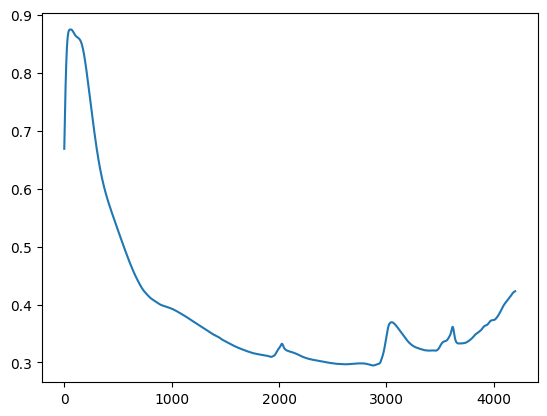

In [10]:
# plot it
plt.plot(inp[:-2])
plt.show()

### Create train and validation dataloader

In [11]:
# create train dataloader
trainloader = torch.utils.data.DataLoader(
    train_ds,
    batch_size = batch_size,
    drop_last = True,
    shuffle = True,
    num_workers = 8
)
# create validation dataloader
valloader = torch.utils.data.DataLoader(
    val_ds,
    batch_size = batch_size,
    drop_last = False,
    shuffle = False,
    num_workers = 8
)

### Define network

In [18]:
class Net(nn.Module):

    def __init__(self):
        # init superclass
        super(Net, self).__init__()
        self.out1 = 16
        self.out2 = self.out1 * 2 # 32
        self.out3 = self.out2 * 2 # 64
        self.out4 = self.out3 * 2 # 128
        self.out5 = self.out4 * 2 # 256
        self.out6 = self.out5 * 2 # 512
        self.out7 = int(self.out6 / 4) # 128

        self.conv1 = nn.Conv1d(in_channels=nr_input_features, out_channels=self.out1, kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(in_channels=self.out1, out_channels=self.out2, kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(in_channels=self.out2, out_channels=self.out3, kernel_size=3, stride=2)
        self.conv4 = nn.Conv1d(in_channels=self.out3, out_channels=self.out4, kernel_size=3, stride=2)
        self.conv5 = nn.Conv1d(in_channels=self.out4, out_channels=self.out5, kernel_size=3, stride=2)
        self.conv6 = nn.Conv1d(in_channels=self.out5, out_channels=self.out6, kernel_size=3, stride=2)
        self.batchNorm1 = nn.BatchNorm1d(self.out1)
        self.batchNorm2 = nn.BatchNorm1d(self.out2)
        self.batchNorm3 = nn.BatchNorm1d(self.out3)
        self.batchNorm4 = nn.BatchNorm1d(self.out4)
        self.batchNorm5 = nn.BatchNorm1d(self.out5)
        self.batchNorm6 = nn.BatchNorm1d(self.out6)
        self.fc1 = nn.Linear(self.out6, self.out7)
        self.fc2 = nn.Linear(self.out7, nr_output_features)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.batchNorm1(self.conv1(x)))
        x = F.relu(self.batchNorm2(self.conv2(x)))
        x = F.relu(self.batchNorm3(self.conv3(x)))
        x = F.relu(self.batchNorm4(self.conv4(x)))
        x = F.relu(self.batchNorm5(self.conv5(x)))
        x = F.relu(self.batchNorm6(self.conv6(x)))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        return x
    
net = Net()
net.to(device)

Net(
  (conv1): Conv1d(4202, 16, kernel_size=(3,), stride=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(2,))
  (conv5): Conv1d(128, 256, kernel_size=(3,), stride=(2,))
  (conv6): Conv1d(256, 512, kernel_size=(3,), stride=(2,))
  (batchNorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc

Define a loss function and optimizer

Let's use a Regression [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) loss and [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer. [learning rate scheduler](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#fad1)



In [19]:
import torch.optim as optim  # Optimization algorithms for training the model
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 50  # Number of training epochs
# criterion = F.mse_loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler

### Perform training with fine-tuning

In [20]:
best_value = None
train_mse = None
val_mse = None

for epoch in tqdm(range(epochs)):
    net.train()
    writer.add_scalar('Epoch', epoch, epoch)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.mse_loss(outputs, labels, reduction='sum')
        loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/train', loss, epoch * len(trainloader) + i)

    net.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = F.mse_loss(outputs, labels, reduction='sum')
            val_running_loss += loss.item()

            writer.add_scalar('Loss/val', val_running_loss, epoch * len(valloader) + i)

    writer.add_scalars('Loss/epoch', {'train': running_loss, 'val': val_running_loss}, epoch)

    if best_value is None or running_loss < best_value:
        best_value = running_loss
        torch.save(net.state_dict(), f'./models/{experiment_name}.pth')
        print('Saved model')

writer.close()

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [16, 4202, 3], expected input[1, 100, 4202] to have 4202 channels, but got 100 channels instead